# Save to numpy data

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Import neccessary libraries

In [2]:
import os
import sys
import glob
import cv2

import pandas as pd
import numpy as np
from natsort import natsorted
import shutil
import matplotlib
matplotlib.use('TkAgg')
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize

%matplotlib notebook 

# Global setups

In [11]:
# Global variables
vth_dir = 'data/VB_0519/VTH/'
z_dir = 'data/VB_0519/Z/'
h_dir = 'data/VB_0519/H/'

dimx = 465 + 2
dimy = 324 + 2
dimt = 1

# vth_name = 'vth'+'_'+str(dimt).zfill(4) \
#                 +'_'+str(dimy).zfill(4) \
#                 +'_'+str(dimx).zfill(4)+'.npy'
# z_name   =   'z'+'_'+str(dimt).zfill(4) \
#                 +'_'+str(dimy).zfill(4) \
#                 +'_'+str(dimx).zfill(4)+'.npy'
# h_name   =   'z'+'_'+str(dimt).zfill(4) \
#                 +'_'+str(dimy).zfill(4) \
#                 +'_'+str(dimx).zfill(4)+'.npy'
# print(vth_name)
# print(z_name)
# print(h_name)

vth_files = natsorted(glob.glob(os.path.join(vth_dir, '*.dat')))
z_files = natsorted(glob.glob(os.path.join(z_dir, '*.grd')))
h_files = natsorted(glob.glob(os.path.join(h_dir, '*.grd')))

debug = False

# Parse *.dat and *.grd files

In [12]:
######################################################################
def parse_dat(file_name, verbose=True):
    dat_str = np.genfromtxt(file_name, delimiter = ' ', dtype='unicode')
    if verbose: print(dat_str)
    dat = []
    for row in dat_str:
        dat.append(np.float32(row.split()))
    dat = np.array(dat, dtype=np.float32)
    if verbose: print(dat.shape)
    return dat

######################################################################
def parse_grd(file_name, verbose=True):
    grd_str = np.genfromtxt(file_name, delimiter = ' ', dtype='unicode')
    if verbose: print(grd_str.shape)
    if verbose: print(grd_str[:5])
    grd = []
    for row in grd_str[5:]: # Parse from the line number 5th
        grd.append(np.float32(row.split()))
    grd = np.array(grd, dtype=np.float32)
    if verbose: print(grd.shape)
    return grd

# Drawing here

(149872, 5) (326, 467) (326, 467)
(326, 467) (326, 467)
(326, 467, 1) (326, 467, 1) (326, 467, 1)
(326, 467, 1) (326, 467, 1) (326, 467, 1) (326, 467, 1)


<IPython.core.display.Javascript object>


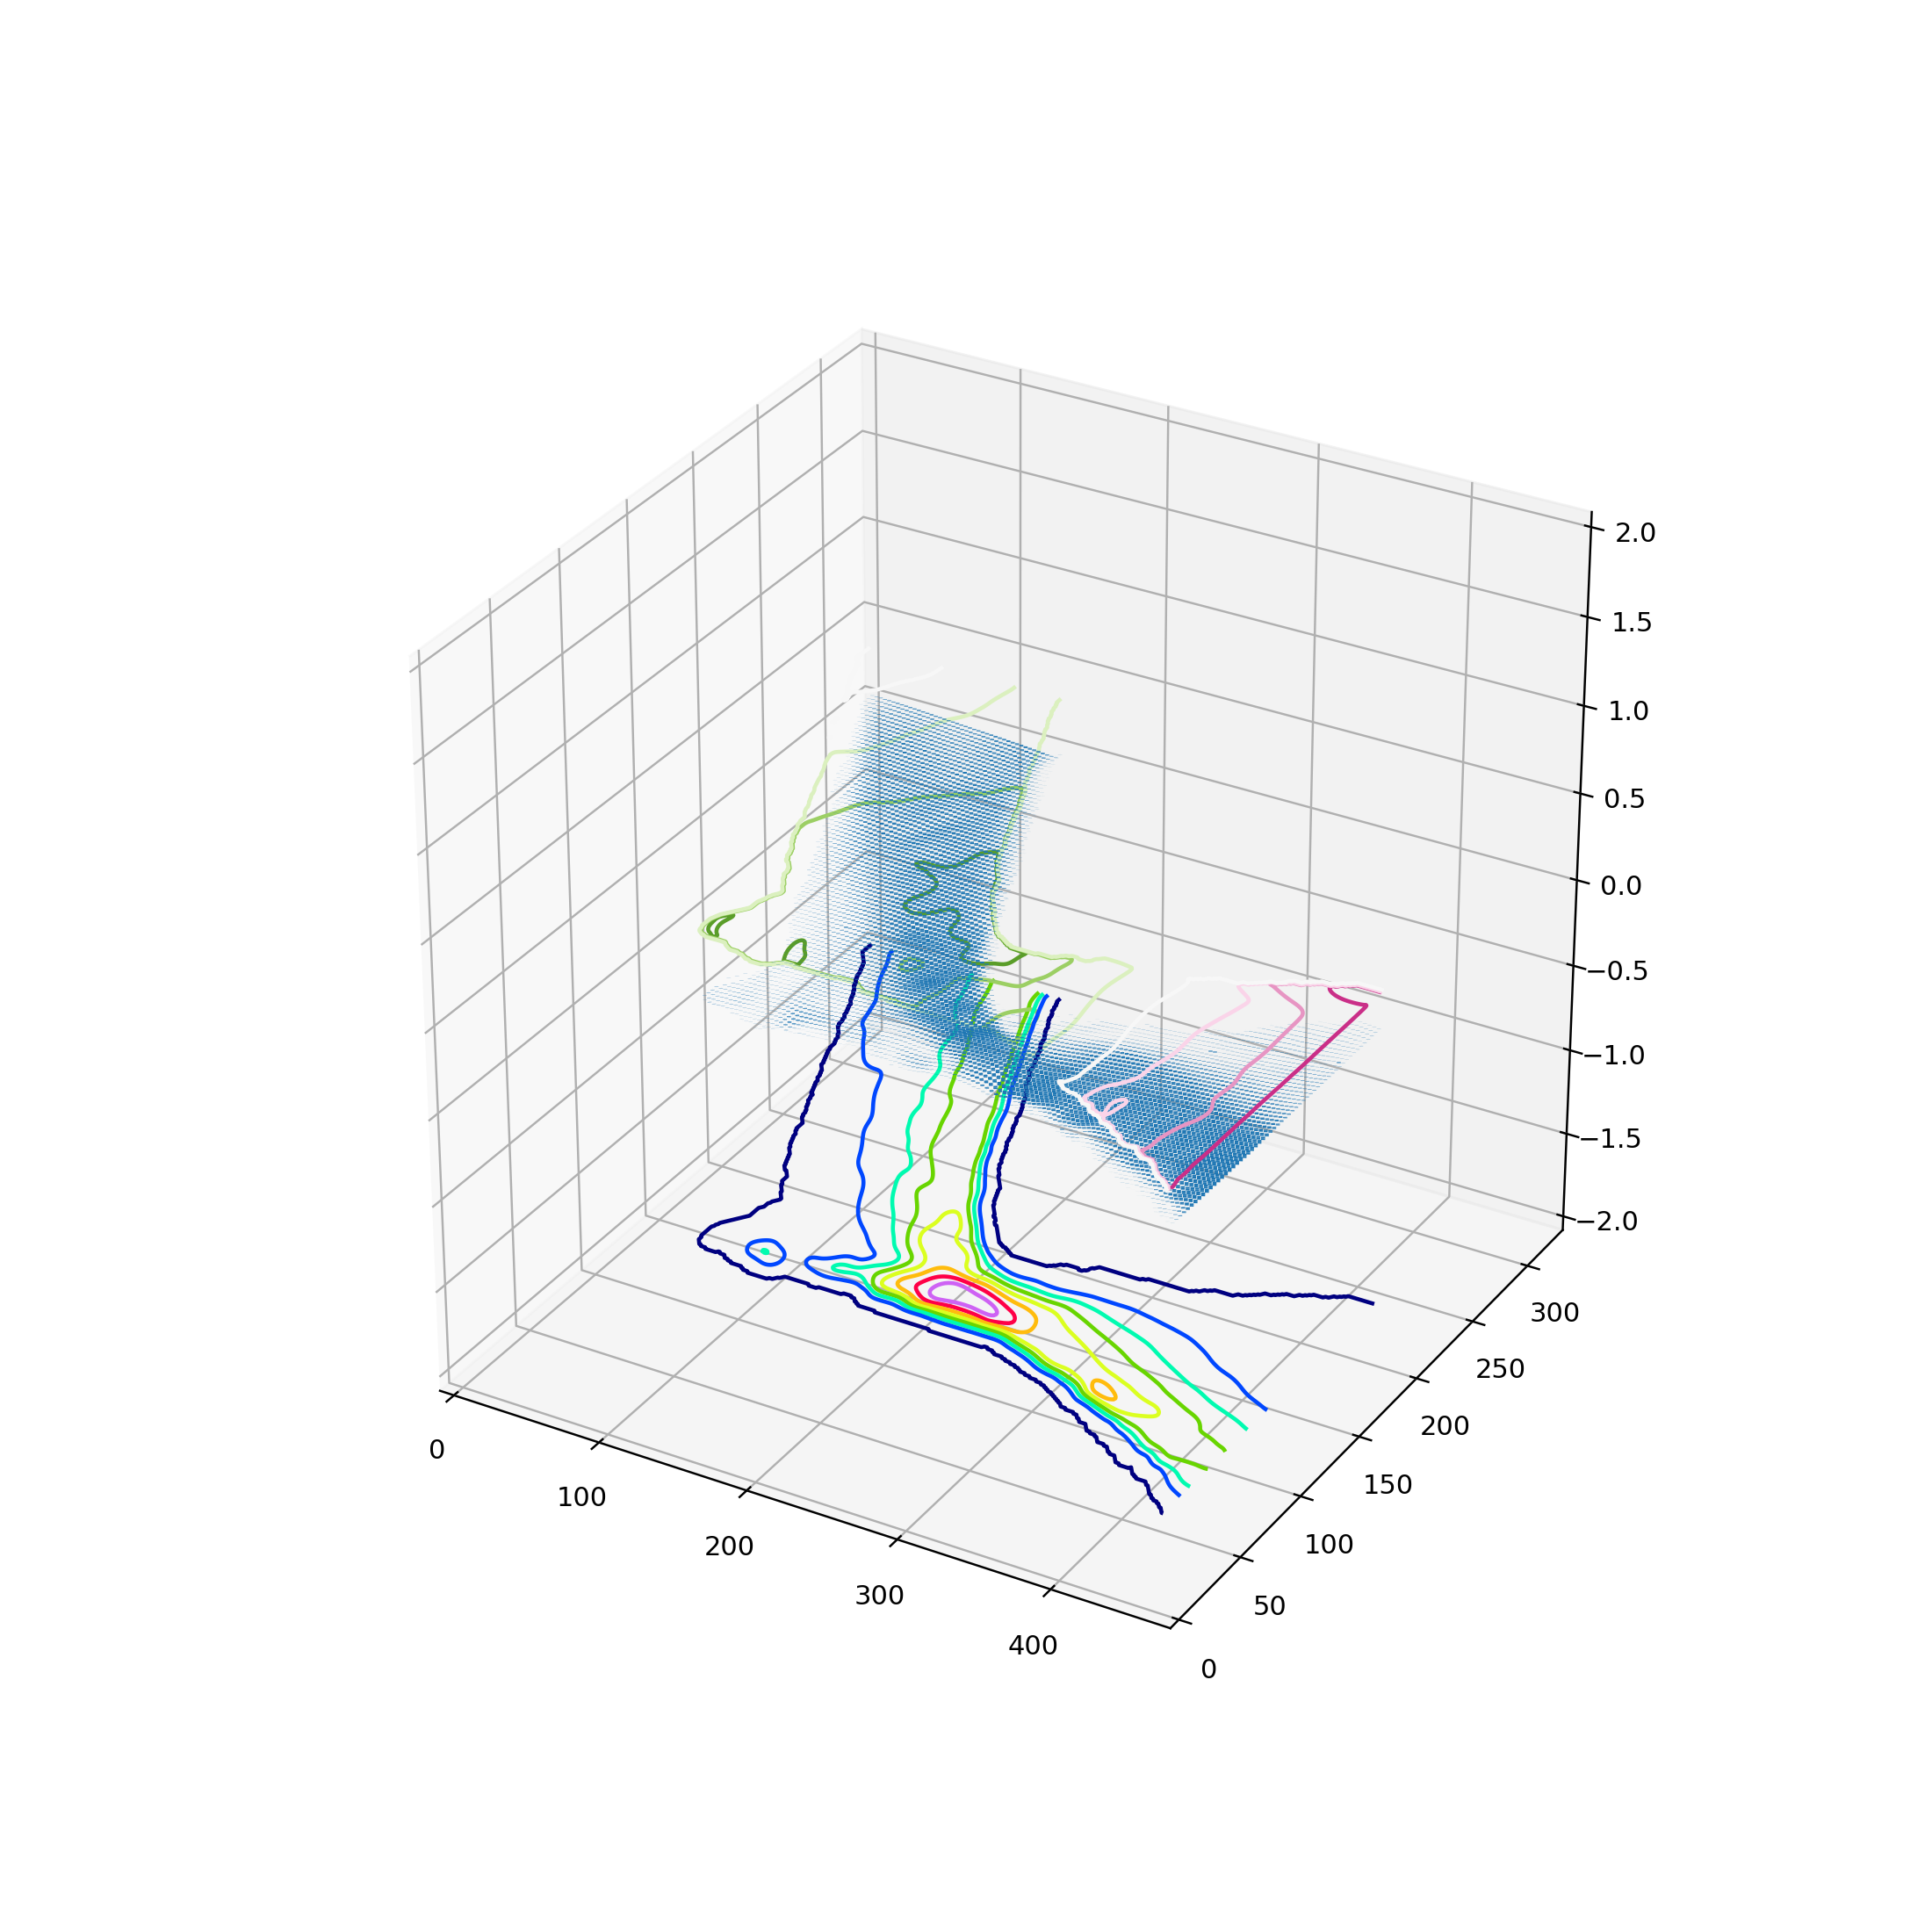

In [22]:
######################################################################
# fig = plt.figure(figsize=(10, 10))
# ax = fig.gca(projection='3d')


shutil.rmtree('result', ignore_errors=True)
os.makedirs('result')
######################################################################   
for t in range(dimt):
    ######################################################################
    # Read the data
    vth_data = parse_dat(vth_files[t], verbose=debug).astype(np.float32)
    z_data = parse_grd(z_files[t], verbose=debug).astype(np.float32)
    h_data = parse_grd(h_files[0], verbose=debug).astype(np.float32)
    
    # Resize the z and h_data
    z_data = cv2.resize(z_data, (dimx, dimy))
    h_data = cv2.resize(h_data, (dimx, dimy))
    
    # Get the magnitude and phase of vector field
    mag = np.zeros((dimy, dimx), dtype=np.float32)
    mag[vth_data[...,2].astype(np.int32), 
        vth_data[...,1].astype(np.int32)] = vth_data[...,3] # Magnitude

    # Take the angle
    deg = np.zeros((dimy, dimx), dtype=np.float32)
    deg[vth_data[...,2].astype(np.int32), 
        vth_data[...,1].astype(np.int32)] = vth_data[...,4] # Phase
    
    print(vth_data.shape, mag.shape, deg.shape)
    print(z_data.shape, h_data.shape)
    # Convert angle to degree
    rad = np.deg2rad(deg)
    num = mag * np.exp(1j*rad)

    u = np.real(num) 
    v = np.imag(num) 
    
    # Color the phase of each vector
    norm = Normalize()
    norm.autoscale(rad.flatten())
    cmap = plt.cm.PiYG #PiYG #BuGn
    
    ######################################################################
    # Grid setups
    yy, xx, zz = np.mgrid[0:dimy,0:dimx, 0:1:40]

    if True: print(xx.shape, yy.shape, zz.shape)
   
    ut = np.expand_dims(u, -1)
    vt = np.expand_dims(v, -1)
    zt = np.expand_dims(z_data, -1)
    ht = np.expand_dims(h_data, -1)
    if True: print(ut.shape, vt.shape, zt.shape, ht.shape)
    ######################################################################
    # Ensure that the next plot doesn't overwrite the first plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    plt.gcf()

    s = 3 # stride
    i = t%s # For alternating the quiver
    dict_pivot = {0: 'tail', 
                  1: 'middle', 
                  2: 'tip'}
    ######################################################################
    # Plot the vector flow
    ax.quiver3D(xx[i::s,i::s,:], yy[i::s,i::s,:], zt[i::s,i::s,:], 
                ut[i::s,i::s,:],
                vt[i::s,i::s,:],
                np.zeros_like(zt[i::s,i::s,:]),
                length=0.1,
                arrow_length_ratio=0.3,
                pivot= dict_pivot[i], #'tail', 
                #normalize=True,
                #color=cmap(norm(rad.flatten())),
                cmap=cm.PiYG, 
                norm=colors.LogNorm(vmin=rad.min(),vmax=rad.max())
              #pivot='tail', 
              #color=cmap(norm(rad.flatten())),
              #length=0.1,
              #lw=2,
              #normalize=False,
              #arrow_length_ratio=0.1,
              )
#     # Plot the surface of water
#     ax.plot_surface(np.squeeze(xx), 
#                     np.squeeze(yy), 
#                     np.squeeze(zt), 
#                     cmap=cm.PiYG_r,
#                     rstride=1, cstride=1, 
#                     alpha=1)
    # Draw the contour of depth 
    cset = ax.contour(np.squeeze(xx), 
                      np.squeeze(yy), 
                      np.squeeze(zt), 
                      zdir='z', 
                      offset=0.3, # Modify here
                      cmap=cm.PiYG_r)
    ######################################################################
#     # Draw the surface of the depth
#     ax.plot_surface(np.squeeze(xx), 
#                     np.squeeze(yy), 
#                     np.squeeze(ht), 
#                     cmap=cm.PiYG_r,
#                     rstride=8, cstride=8, 
#                     alpha=0.5)
    # Draw the contour of depth 
    cset = ax.contour(np.squeeze(xx), 
                      np.squeeze(yy), 
                      np.squeeze(ht), 
                      zdir='z', 
                      offset=-1.5, # Modify here
                      cmap=cm.gist_ncar)
    ######################################################################
    
    # Set the view
    ax.set_xlim3d(0, dimx)
    ax.set_ylim3d(0, dimy)
    ax.set_zlim3d(-2, 2)

#     ax.view_init(+20, # +30  
#                  -70, # -70 
#                 )
    
    ax.initial_azim = 120 #-120 #-60
    ax.initial_elev = 60 #30 #12
    ax.dist = 10
#     ax.indicate_inset_zoom = 0.1
#     plt.show()
    ######################################################################
    plt.savefig('result/'+str(t).zfill(4)+'.png', bbox_inches='tight')
    #plt.show()
    plt.gca().axes.get_xaxis().set_visible(True)
    #plt.close()

In [23]:
print('ax.azim {}'.format(ax.azim))
print('ax.elev {}'.format(ax.elev))
print('ax.dist {}'.format(ax.dist))

ax.azim -60
ax.elev 30
ax.dist 10


In [8]:
ax.can_pan()
ax.can_zoom()

False

In [9]:
!ls

README.md                           Visualization_depth.ipynb
Simple_example_vi.ipynb             Visualization_depth_ipyvolume.ipynb
Visualization.ipynb                 Visualization_matplotlib.ipynb
Visualization_clean_VB.ipynb        Visualize_depth.ipynb
Visualization_clean_single_VB.ipynb data
Visualization_debug.ipynb           result
